In [1]:
import math
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal

In [2]:
# Name of the directory where image files will be store
IMAGE_DIRECTORY = 'images'

# Names of the possible game scenarios
SELFISH = 'selfish'
PROSOCIAL = 'prosocial'
MIXED = 'mixed'

# Create the directory for images if not existing yet
if not os.path.exists(IMAGE_DIRECTORY):
    os.makedirs(IMAGE_DIRECTORY)

In [ ]:
def get_jain_index(resources):
    """Calculates the Jain index of a list of resources."""

    # Jain fairness index
    # index close to 1 means fair distribution of resources
    # index close to 1/n means unfair distribution of resources

    n = resources.shape[0]
    r = resources

    if n <= 1:
        return 1.0
    else:
        return ((np.sum(r) ** 2) / (np.sum(r ** 2) * n))

In [4]:
def get_jain_index_max(np, nc):
    """Calculates the maximum possible value of the Jain index."""
    x = nc/np
    d = x - int(x)
    index = (1 + d*(1-d)/(x*x))**-1
    return index

In [5]:
def round_float(num, decimal_place=0, direction=floor):
    """Rounds a float number given a decimal place."""
    return direction(num * (10**decimal_place)) / float(10**decimal_place)

In [6]:
def are_max_values_first(resources):
    """Returns True if the first resource of the list is the maximum value."""
    
    v1 = resources[0]
    is_max = True
    for r in range(len(resources)-1):
        if resources[r+1] > resources[r]:
            is_max = False
            break

    return is_max

In [7]:
# The three following functions are used
# to display results in the for of images


def show_heatmap(data, ax, max_gain, min_gain, epi=50):

    """Generates an image containing a heatmap image"""
    (n, p) = np.shape(data)

    data_n = np.ma.masked_array(data, data < 0)
    data_p = np.ma.masked_array(data, data >= 0)

    pa = ax.imshow(data_n, interpolation='nearest',
                   # cmap="Greens", vmin=0, vmax=max_gain)
                   cmap="binary", vmin=0, vmax=int(max_gain/3*4))
    pb = ax.imshow(data_p, interpolation='nearest',
                   # cmap="gist_gray", vmin=min_gain, vmax=0)
                   cmap="gist_gray", vmin=int(min_gain/3*4), vmax=0)

    # im = ax.imshow(data)

    # We want to show all ticks...
    ax.set_xticks(np.arange(p))
    ax.set_yticks(np.arange(n))

    # ax.set_title("Episode n°"+str(epi))
    yLabels = ["P"+str(i) for i in range(1, p+1)]
    # xLabels = ["" for i in range(p)]
    xLabels = ["C"+str(i+1) for i in range(p)]  # npr. C1, C2, C3...
    ax.set_xticklabels(xLabels)
    ax.set_yticklabels(yLabels)

    # Loop over data dimensions and create text annotations.
    for i in range(n):
        for j in range(p):
            if j < i:
                # data[i, j] corresponds to a dead pirate (N/A)
                # so hide it by displaying it in "white" color
                text = ax.text(j, i, data[i, j],
                               ha="center", va="center", color="white")
            else:
                text = ax.text(j, i, data[i, j],
                               ha="center", va="center", color="black")


def show_graph(error_data, reward_data, t, ax, max_episodes=1,
               min_error_data=0, max_error_data=50,
               min_reward_data=0, max_reward_data=2):
    """Generates a performance graph image"""
    # t = np.arange(1, len(error_data)+1)

    color = 'sandybrown'

    ax.set_xlim(1, max_episodes)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Gain Error', color=color)

    ax.plot(t, error_data, color=color)
    ax.tick_params(axis='y', labelcolor=color)

    ax.set_ylim(min_error_data, max_error_data)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'skyblue'
    # we already handled the x-label with ax1
    ax2.set_ylabel('Reward Planner', color=color)
    ax2.plot(t, reward_data, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.set_ylim(min_reward_data, max_reward_data)
    # fig.tight_layout()


def build_images(data, error_data, reward_data, t, image_label, i_epi=50,
                 max_episodes=1, min_error_data=0, max_error_data=50,
                 min_reward_data=0, max_reward_data=2,
                 figsize=(10, 17), max_gain=10, min_gain=-3):
    """Generates an image containing a heatmap image and a
    performance graph image.
    """

    # Make a single_image with 2 sub images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax2.figure.set_size_inches(20, 5)
    show_heatmap(data, ax1, max_gain, min_gain, epi=i_epi)
    show_graph(error_data, reward_data, t, max_episodes=max_episodes,
               min_error_data=min_error_data,
               max_error_data=max_error_data,
               min_reward_data=min_reward_data,
               max_reward_data=max_reward_data,
               ax=ax2)
    fig.savefig(IMAGE_DIRECTORY + '/' + image_label + '.png')

    # Draw again each image separately
    fig, (ax1) = plt.subplots(1, 1, figsize=figsize)
    ax1.figure.set_size_inches(4, 4)
    show_heatmap(data, ax1, max_gain, min_gain, epi=i_epi)
    fig.savefig(IMAGE_DIRECTORY + '/' + image_label+'_heat' + '.png')

    fig, (ax2) = plt.subplots(1, 1, figsize=figsize)
    ax2.figure.set_size_inches(5, 4)
    show_graph(error_data, reward_data, t, max_episodes=max_episodes,
               min_error_data=min_error_data,
               max_error_data=max_error_data,
               min_reward_data=min_reward_data,
               max_reward_data=max_reward_data,
               ax=ax2)
    fig.savefig(IMAGE_DIRECTORY + '/' + image_label+'_graph' + '.png')

In [8]:
#%%pycodestyle
class Environment:

    def __init__(self, n_pirates=3, n_coins=5):
        self.n_pirates = n_pirates
        self.n_coins = n_coins
        self.decider_rank = 0
        # list indicating the state of each pirate:
        # alive (True) or dead (False)
        self.living_pirates = np.ones(self.n_pirates, dtype='bool')
        self.state = np.zeros(self.n_pirates)
        self.state[self.decider_rank] = 1

    def reset(self):
        self.state = np.zeros(self.n_pirates)
        self.decider_rank = np.random.randint(self.n_pirates)
        self.living_pirates = np.ones(self.n_pirates, dtype='bool')
        self.state = np.zeros(self.n_pirates)
        self.state[self.decider_rank] = 1
        for i in range(self.decider_rank):
            self.living_pirates[i] = False

        return(self.state)

    def step(self, plan, votes):
        # plan is an numpy integer dim and votes is a list of Bool

        decider_rank = self.decider_rank

        # calculate whether the plan is accepted or not by the majority
        plan_accepted = np.array(votes).astype(int).sum() >= len(votes)/2

        # Rewards in order of priority:
        # 1. to live
        # 2. to earn coins
        # 3. to kill other pirates

        r_death = -1        
        r_others = 0.1

        # Definition of Rewards and Dones
        # Init the rewards of all pirates (dead or not)
        rewards = np.zeros(self.n_pirates)
        dones = np.ones(self.n_pirates, dtype='bool')

        targets = np.zeros(self.n_pirates)
        targets[decider_rank] = self.n_coins-1

        # The plan is accepted, all living_pirates pirates receive 
        # a reward exponential to the number of coins
        # The game is finished, hence done equals true for all pirates
        if plan_accepted:
            for i in range(decider_rank, self.n_pirates):
                rewards[i] = math.exp(plan[i])
                dones[i] = True

        # The plan is not accepted, the decision maker dies and hence
        # get a negative r_death rewards, whereas the other pirates
        # receive a tiny reward (r_others)
        # The game is only finished for the newly dead pirate
        else:
            for i in range(decider_rank+1, self.n_pirates):
                rewards[i] = r_others
                dones[i] = False
            rewards[decider_rank] = r_death
            self.living_pirates[decider_rank] = False
            self.decider_rank += 1

        self.state = np.zeros(self.n_pirates)
        self.state[min(self.decider_rank, self.n_pirates-1)] = 1

        return self.state, rewards, dones

In [9]:
def distri_to_plan(distribution, n_pirates):
    """ Transforms a distribution (earner of each coin) to a plan (repartition)
    example : distribution (tensor) of 5 n_coins = [0,0,0,1,2]
    (3 n_coins go with pirate n°0, 1 with n°2 and 1 with n°3) -> [3,1,1]
    """
    distribution = distribution.numpy()
    plan = np.zeros(n_pirates)
    for i in range(distribution.size):
        plan[distribution[i]] += 1
    return plan

In [10]:
def get_optimal_distri_selfish(n_pirates, n_coins):
    """ Calculates the optimal matrix solution for the Pirate Games.
    This may be used as a baseline when evaluating results of a model."""
    mat = np.zeros([n_pirates+1, n_pirates])

    for i in range(n_pirates):
        mat[i, i] = n_coins - int((n_pirates-i-1)/2)

        for j in range(i+2, n_pirates, 2):
            mat[i, j] = 1

    return mat

In [11]:
def get_optimal_distri_prosocial(n_pirates, n_coins):
    """ Calculates the optimal matrix solution for an alternative of
    the Pirate Games where pirates vote prosocially
    This may be used as a baseline when evaluating the results of a model."""
    mat = np.zeros([n_pirates+1, n_pirates])

    for i in range(n_pirates):
        mat[i, i] = int(n_coins/(n_pirates-i))

        for j in range(i+1, n_pirates, 1):
            mat[i, j] = int(n_coins/(n_pirates-i))

        remaining_coins = int(n_coins % (n_pirates-i))
        for j in range(i, n_pirates, 1):
            if remaining_coins > 0:
                mat[i, j] += 1
                remaining_coins -= 1

    return mat

In [12]:
def get_optimal_distri_mixed(n_pirates, n_coins):
    """ Calculates the optimal matrix solution for an alternative
    of the Pirate Games.
    This may be used as a baseline when evaluating the results of a model."""
    mat = np.zeros([n_pirates+1, n_pirates])

    # optimal solution is selfish when only one or two pirates remain
    for i in range(n_pirates-2, n_pirates):
        mat[i, i] = n_coins - int((n_pirates-i-1)/2)

        for j in range(i+2, n_pirates, 2):
            mat[i, j] = 1

    # optimal solution is prosocial when more pirates
    for i in range(n_pirates-2):
        mat[i, i] = int(n_coins/(n_pirates-i))

        for j in range(i+1, n_pirates, 1):
            mat[i, j] = int(n_coins/(n_pirates-i))

        remaining_coins = int(n_coins % (n_pirates-i))
        for j in range(i, n_pirates, 1):
            if remaining_coins > 0:
                mat[i, j] += 1
                remaining_coins -= 1

    return mat

In [13]:
def get_optimal_distri(n_pirates, n_coins, scenario):
    """ Calculates the optimal matrix solution for the Pirate Games.
    This may be used as a baseline when evaluating results of a model."""
    if scenario == SELFISH:
        # optimal distribution according to the pirate game rules
        optimal_distri = get_optimal_distri_selfish(n_pirates, n_coins)
    elif scenario == PROSOCIAL:
        # optimal distribution according to a new rule involving
        # some degree of fairness
        optimal_distri = get_optimal_distri_prosocial(n_pirates, n_coins)
    elif scenario == MIXED:
        optimal_distri = get_optimal_distri_mixed(n_pirates, n_coins)
    else:
        raise Exception("reinforce_pirates(): scenario=%s not implemented", scenario)
    return optimal_distri

In [14]:
def show_optimal_distri(n_pirates, n_coins, scenario=SELFISH):
    if scenario == SELFISH:
        optimal_distri = get_optimal_distri_selfish(n_pirates, n_coins)
    elif scenario == PROSOCIAL:
        optimal_distri = get_optimal_distri_prosocial(n_pirates, n_coins)
    elif scenario == MIXED:
        optimal_distri = get_optimal_distri_mixed(n_pirates, n_coins)
    else:
        raise Exception('show_optimal_distri(): scenario %s not implemented',
              scenario)

    optimal_distri = optimal_distri[:-1, ]
    print(optimal_distri)

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 17))
    ax1.figure.set_size_inches(4, 4)
    show_heatmap(optimal_distri, ax1, n_coins, 0, epi=0)
    image_label = str(n_pirates) + 'p_' + str(n_coins) + 'c_' + \
        scenario + '_optimal_plan'

    fig.savefig(IMAGE_DIRECTORY + '/' + image_label + '.png')

[[ 8.  0.  1.  0.  1.]
 [ 0.  9.  0.  1.  0.]
 [ 0.  0.  9.  0.  1.]
 [ 0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0. 10.]]


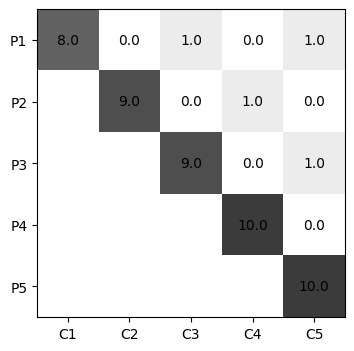

In [15]:
show_optimal_distri(5, 10, SELFISH)

[[ 2.  2.  2.  2.  2.]
 [ 0.  3.  3.  2.  2.]
 [ 0.  0.  4.  3.  3.]
 [ 0.  0.  0.  5.  5.]
 [ 0.  0.  0.  0. 10.]]


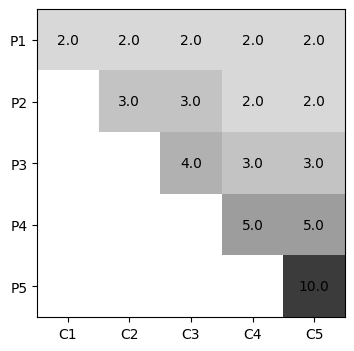

In [16]:
show_optimal_distri(5, 10, PROSOCIAL)

[[ 2.  2.  2.  2.  2.]
 [ 0.  3.  3.  2.  2.]
 [ 0.  0.  4.  3.  3.]
 [ 0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0. 10.]]


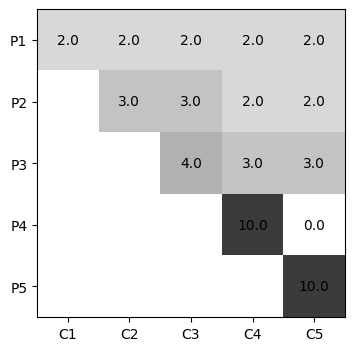

In [18]:
show_optimal_distri(5,10, MIXED)

In [19]:
def get_probs(n_pirates, n_coins, decider_rank):

    coin_probs = []
    for rank in range(n_pirates):
        if rank  < decider_rank:
            coin_probs.append(0.0)
        else:
            coin_probs.append(1/(n_pirates - decider_rank))
    coins_probs = []
    for coin in range(n_coins):
        coins_probs.append(coin_probs)
    return torch.Tensor(coins_probs)

In [20]:
# Identify which device should be used by torch for the ANN calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Planner(nn.Module):
    def __init__(self, n_pirates=3, n_coins=5):
        super(Planner, self).__init__()
        self.n_pirates = n_pirates
        self.n_coins = n_coins
        h_size = int(n_pirates*n_coins)
        a_size = n_pirates*n_coins
        self.fc1 = nn.Linear(n_pirates, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.epsilon = 0.1

    def forward(self, x, decider_rank):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)

        n = out.size()
        mask = torch.zeros(n).to(device)

        # Penalize the dead pirates by adding the a huge negative value
        # so that no coins will be given to them
        for i in range(decider_rank):
            for k in range(self.n_coins):
                mask[0][self.n_pirates*k+i] = -10000

        out = out + mask

        return out

    def act(self, state, add_noise=True):

        decider_rank = np.argmax(state)

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        probs_total = self.forward(state, decider_rank).cpu()
        probs_total = probs_total.view([-1, self.n_pirates])
        probs_total = F.softmax(probs_total, dim=1)

        m = Categorical(probs_total)

        if add_noise and np.random.rand() < self.epsilon:
            # proba = (1/self.n_pirates) * torch.ones([self.n_coins, self.n_pirates])
            proba = get_probs(self.n_pirates, self.n_coins, decider_rank)
            uniform = Categorical(proba)
            action = uniform.sample()
        else:
            action = m.sample()

        return action, m.log_prob(action)

In [21]:
class Voter():
    def __init__(self, n_pirates=3, n_coins=5, scenario=SELFISH):
        self.n_pirates = n_pirates
        self.n_coins = n_coins
        self.V = np.zeros([self.n_pirates+1, self.n_pirates])
        self.scenario = scenario
        self.epsilon = 0.01

    def act(self, voter_rank, plan, n_living_pirates, add_noise=True):

        pirate_highest_rank = self.n_pirates - n_living_pirates
        
        # Determine the voting behavior to be done by the pirate
        if self.scenario == SELFISH:
            behavior = SELFISH
        elif self.scenario == PROSOCIAL:
            behavior = PROSOCIAL
        elif self.scenario == MIXED:                
            if voter_rank == pirate_highest_rank:            
                behavior = SELFISH
            else:
                behavior = PROSOCIAL
        else:
            raise Exception("Scenario %s not implemented" % self.scenario) 

        if add_noise and np.random.rand() < self.epsilon:
            uniform = Categorical(0.5*torch.ones([1, 2]))
            action = uniform.sample()
        else:
            
            if behavior == SELFISH:
                # Selfish behavior. Vote according to the rules of the pirate game)
                # proposed gain for the current voting pirate
                gain_plan = plan[voter_rank]

                # maximum reward if the current planner were dead. This reward
                # is on the next line but in the same column
                reward_max = self.V[self.n_pirates-n_living_pirates+1, voter_rank]
                
                action = gain_plan > reward_max or gain_plan == self.n_coins
            elif behavior == PROSOCIAL:
                # Prosocial behavior (i.e. another rule that the pirate game rule)
                # action based on some degree of fairness
                # e.g. [11, 10, 10] -> jain index = 0.998
                # and on some degree of greediness
                # e.g. P-0 prefer [11, 10, 10] rather than [10, 11, 10]
                jain = get_jain_index(plan[-n_living_pirates:])
                jain_max = get_jain_index_max(n_living_pirates, self.n_coins)

                jain = round_float(jain, 2)
                jain_max = round_float(jain_max, 2)

                first_max = are_max_values_first(plan[-n_living_pirates:])
                action = (jain == jain_max) and first_max
            else:
                raise Exception("Scenario %s not implemented" % self.scenario)

        return bool(action)

In [22]:
def evaluate_planner(planner, n_pirates):
    '''Computes one evaluation of the current planner's model'''
    resultat = []
    for i in range(n_pirates):
        state = np.zeros(n_pirates)
        state[i] = 1
        action, pr = planner.act(state, add_noise=False)
        plan = distri_to_plan(action, n_pirates)
        resultat.append(plan)
    return np.array(resultat)

In [23]:
def evaluate_planner_mean(planner, n_pirates, k):
    '''Computes the mean of k-evaluations of the current model'''
    liste = []
    for i in range(k):
        liste.append(evaluate_planner(planner, n_pirates))

    final = np.zeros([n_pirates, n_pirates])

    for res in liste:
        final += res

    return final/k

In [24]:
#%%pycodestyle


def reinforce_pirates(n_pirates=5, n_coins=10, n_episodes=7000,
                      scenario=SELFISH, print_every=1, single_image=True):

    env = Environment(n_pirates, n_coins)
    planner = Planner(n_pirates, n_coins).to(device)
    optimizer_planner = optim.Adam(planner.parameters(), lr=0.01)
    voter = Voter(n_pirates, n_coins, scenario)

    # Create a FIFO to store the planner last 100 results
    planner_recent_scores = deque(maxlen=100)
    planner_scores = []

    # Create a FIFO to store the voter last 100 results
    voter_recent_scores = deque(maxlen=100)
    voter_scores = []

    # Get the optimal distribution.
    # It will be used as a baseline when observing the results.
    optimal_distri = get_optimal_distri(n_pirates, n_coins, scenario)

    abscisses_t = []
    voter_error_data = []
    planner_reward_data = []

    # Voter learning rate
    alpha = 0.1

    for e in range(n_episodes):

        planner_log_probs = []
        planner_rewards = []

        saved_log_probs_voter = [[] for _ in range(n_pirates)]
        voter_rewards = [[] for _ in range(n_pirates)]

        state = env.reset()
        plans = []

        for p in range(n_pirates):

            decider_rank = env.decider_rank
            actions, log_prob_planner = planner.act(state, add_noise=True)
            # state defines the decision maker
            plan = distri_to_plan(actions, env.n_pirates)
            plans.append(plan)

            votes = []
            first_voter = decider_rank

            # Make each living pirate vote
            for p_rank in range(first_voter, n_pirates):
                state_voter = p_rank
                n_living_pirates = env.n_pirates - decider_rank
                vote = voter.act(state_voter, plan, n_living_pirates, add_noise=True)
                votes.append(vote)

            new_state, rewards, dones = env.step(plan, votes)

            state = new_state

            # append the planner's rewards and the planner log prob in history lists
            reward_planner = rewards[decider_rank]
            planner_log_probs.append(log_prob_planner)
            planner_rewards.append(reward_planner)

            # rewards and prob for Voter
            for i in range(env.n_pirates):
                voter_rewards[i].append(rewards[i])

            if dones.all():
                # break if game is over for all, which happens if
                # all pirates are dead or there a distribution as been accepted
                for p_rank in range(env.n_pirates):

                    r = plan[p_rank]
                    if p_rank < env.decider_rank:
                        r = -1
                    # update the estimated reward with this last reward result
                    voter.V[env.decider_rank, p_rank] += alpha *\
                        (r - voter.V[env.decider_rank, p_rank])

                score_values = sum(sum((voter.V-optimal_distri)**2))
                voter_scores.append(score_values)
                voter_recent_scores.append(math.log(score_values))
                break

        planner_scores.append(reward_planner)
        # trick to avoid log(0) 
        if reward_planner <= 0:
            reward_planner = 1e-6
        planner_recent_scores.append(math.log(reward_planner))

        # Trajectories of Planner (size 1)
        planner_loss_list = []

        for reward_planner, log_prob_planner in zip(planner_rewards, planner_log_probs):
            planner_loss_list.append(-log_prob_planner.sum()*reward_planner)

        # Training of Planner
        #for planner_loss in planner_loss_list:
        #    optimizer_planner.zero_grad()
        #    planner_loss.backward()
        #    optimizer_planner.step()

        # Training of Planner
        # perform the training on the last episodes only
        latest_episodes = int(n_episodes/10)
        if e != 0:
            #for planner_loss in planner_loss_list[-latest_episodes:]:
            for planner_loss in planner_loss_list:
                optimizer_planner.zero_grad()
                planner_loss.backward()
                optimizer_planner.step()
            
            # Display the results in images 
        # either periodically (print_every) or last episode
        if e % print_every == 0 or e == (n_episodes-1):

            planner_mean_scores = np.mean(planner_recent_scores)
            voter_mean_scores = np.mean(voter_recent_scores)

            # print('Episode {}\tAverage Score Planner: {:.2f}'.format(e, planner_mean_scores))
            # print('Episode {}\tAverage Score Voter: {:.2f}'.format(e, voter_mean_scores))

            abscisses_t.append(e)
            voter_error_data.append(voter_mean_scores)
            planner_reward_data.append(planner_mean_scores)

            if e != (n_episodes-1):
                continue

            data = evaluate_planner_mean(planner, n_pirates, 500)
            np.set_printoptions(precision=0, suppress=True)
            print(data)

            np.set_printoptions(precision=1, suppress=True)
            image_label = str(n_pirates) + 'p_' +\
                str(n_coins) + 'c_' + scenario +\
                '_' + str(int(e/print_every)+1) + 'e'

            max_error = n_coins
            max_reward = n_coins

            build_images(np.around(data, decimals=2),
                        voter_error_data, planner_reward_data,
                        abscisses_t, image_label, e, n_episodes,
                        min_error_data=0, max_error_data=max_error,
                        min_reward_data=0, max_reward_data=max_reward)
        # End of the episode

    return planner_scores, voter_scores

[[ 2.  2.  2.  2.  2.]
 [ 0.  2.  3.  2.  2.]
 [ 0.  0.  4.  3.  3.]
 [ 0.  0.  0.  5.  5.]
 [ 0.  0.  0.  0. 10.]]
CPU times: total: 17 s
Wall time: 10.1 s


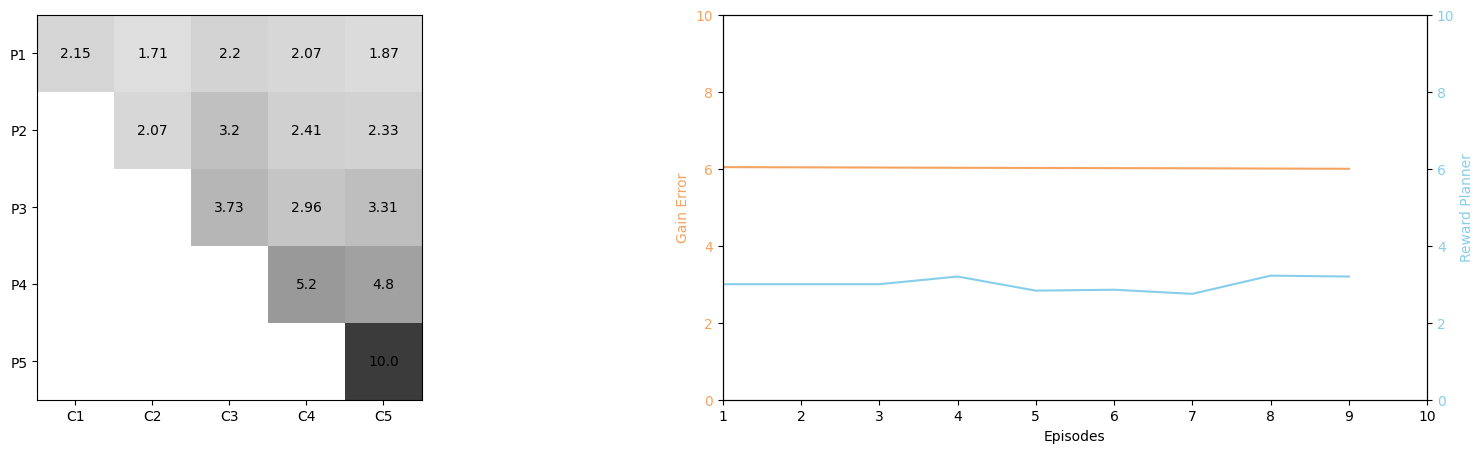

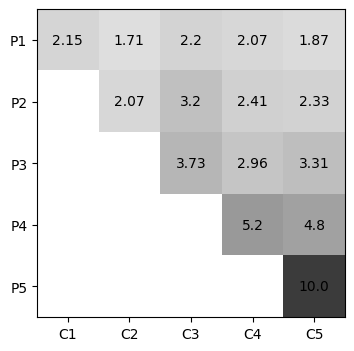

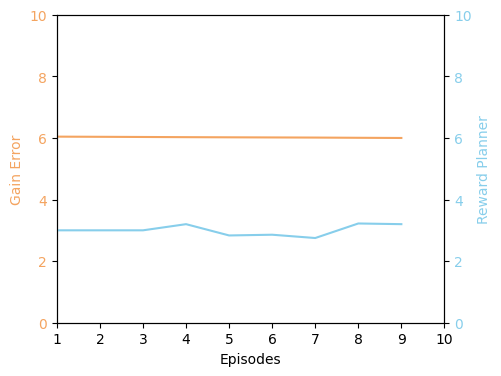

In [25]:
# selfish scenario
# all pirates vote selfishally (i.e. same scenario than the "pirate game")
%time _, _ = reinforce_pirates(n_pirates=5, n_coins=10, n_episodes=10, scenario=SELFISH)